# Training notebook for chord encoder

## Note that the autoencoder trained here is only for encoding single time slices (ie music chords for 5 instruments).
## Time correlation among chords are not encoded and is left for RNN to model as an extention to this project

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import fastai

In [3]:
from fastai import *
from fastai.imports import *
from fastai.layers import SigmoidRange
from fastai.tabular import mean_absolute_error

In [4]:
from scipy import sparse

In [5]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

In [6]:
torch.cuda.is_available()
torch.cuda.set_device(1)
torch.cuda.current_device()

True

1

# What a 5-Track Midi file looks like

In [7]:
import pypianoroll

(<Figure size 720x720 with 5 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f26dbc9b7b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f26d7500630>], dtype=object))

(3000, 4000)

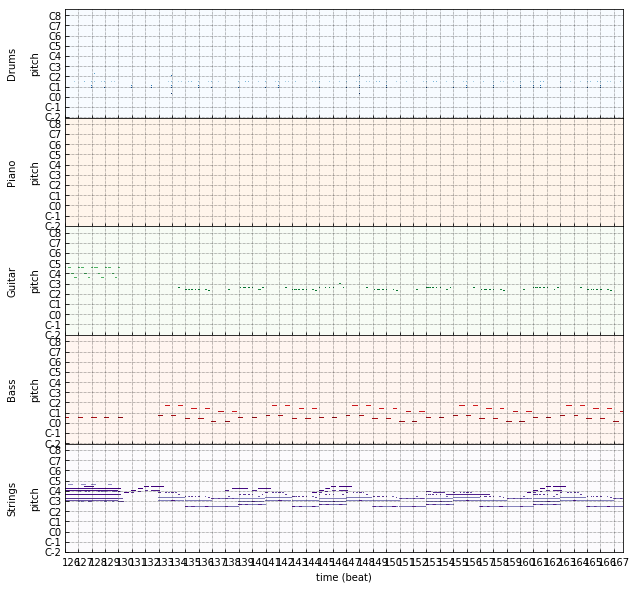

In [8]:
pypianoroll.load('b97c529ab9ef783a849b896816001748.npz').plot()
plt.xlim((3000,4000))

# Loading Data File (small)
### Data file is a list of sparse matrices
#### 5 tracks per song (Drums, Piano, Guitar, Bass and Strings)
#### pitch range: C-1 to G9 (128 pitches)
#### value in each "pixel" = volumn of the note
#### frequency = 24 per beat (quarter note)

In [7]:
datapath=Path('W:/Datasets/Music/lpd_5/lpd_5_cleansed')
datapath

PosixPath('W:/Datasets/Music/lpd_5/lpd_5_cleansed')

In [8]:
# data = pickle.load(open('dataSparse_small1000.pkl','rb'))
# data = data + pickle.load(open('dataSparse_small2000.pkl','rb'))
data = pickle.load(open('dataSparse.pkl','rb'))
len(data) # number of songs
type(data),type(data[0])

21425

(list, scipy.sparse.csr.csr_matrix)

In [9]:
data_val=pickle.load(open('dataSparse_small100.pkl','rb'))  # validation set
len(data_val) # number of songs

100

# Define Pytorch Dataset
### Stack all songs together in the time dimension.
### Each data point is a single time slice because the autoencoder is ONLY responsible to encode chords, ie combination of pitches and instruments

In [10]:
class PianorollDS(Dataset):
    def __init__(self,data):
        self.data = scipy.sparse.vstack(data)
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self,idx):
        return self.data[idx]

### The collate function is called to tell dataloader how to glue together a random batch

In [11]:
def sparse2dense_collate(xs):
    return torch.from_numpy(np.transpose(scipy.sparse.vstack(xs).toarray().reshape(-1,128,5),(0,2,1)))

# Normalization and Denormalization
## currently simply divide by 128

In [12]:
velocity_0lift = 12

In [13]:
def velocityTransform(x):
    return (x.clamp(0,1)*velocity_0lift + x.clamp(0,127)).type(torch.float32)/(128.+velocity_0lift)

In [14]:
velocity_range = np.array([0,127]).astype(np.uint8)
velocity_range_transformed = velocityTransform(torch.tensor(velocity_range))
velocity_range, velocity_range_transformed, velocityTransform(torch.tensor(1).type(torch.uint8))

(array([  0, 127], dtype=uint8), tensor([0.0000, 0.9929]), tensor(0.0929))

In [15]:
def velocityDetransform(x):
    return (( x.clamp(*velocity_range_transformed.numpy())*(128.+velocity_0lift) - velocity_0lift).clamp(*velocity_range) +0.5).type(torch.uint8)

In [16]:
velocityDetransform(velocity_range_transformed)
velocityDetransform(torch.tensor(.51))

tensor([  0, 127], dtype=torch.uint8)

tensor(59, dtype=torch.uint8)

In [17]:
velocityDetransform(velocityTransform(torch.tensor(126).type(torch.uint8)))

tensor(126, dtype=torch.uint8)

# Define Autoencoder

In [18]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder=nn.Sequential(                     #(5,128)
                            nn.Conv1d(5,40,12,groups=5), #(40,117)
                            nn.ReLU(),
                            nn.Conv1d(40,16,18,stride=11,groups=1), # (16,10), (kernel_size = 116-(out_size-1)*stride+1), 116=in_size-1
                            nn.ReLU(),
#                             nn.Conv1d(16,24,10,stride=1,groups=1), # (24,1), (kernel_size = 9-(out_size-1)*stride+1), 9=in_size-1
                            nn.Conv1d(16,87,10,stride=1,groups=1), # (24,1), (kernel_size = 9-(out_size-1)*stride+1), 9=in_size-1
                            nn.Sigmoid(),
                            )
        self.decoder=nn.Sequential(
#                             nn.ConvTranspose1d(24,16,10,stride=1),
                            nn.ConvTranspose1d(87,16,10,stride=1),
                            nn.ReLU(),
                            nn.ConvTranspose1d(16,40,18,stride=11),
                            nn.ReLU(),
                            nn.ConvTranspose1d(40,5,12),
#                             SigmoidRange(-0.7, 5),
                            SigmoidRange(-1.0, 2.0),
#                             nn.Tanh(),
#                             nn.ReLU()
        )

    def forward(self, x):
        encoding = self.encoder(x)
        x = self.decoder(encoding)
        return encoding.view(-1,3,29), x
    
    def get_encoder(self):
        return self.encoder
    def get_decoder(self):
        return self.decoder

In [19]:
autoencoder=Autoencoder().cuda()

# Load saved model

In [20]:
autoencoder.load_state_dict(torch.load('conv_AE_drumFirst_allData-02.pth'))

# Train a bit more

In [54]:
loss_fn = nn.MSELoss().cuda()
optimizer = optim.Adam(autoencoder.parameters(), lr = 2e-5, weight_decay=1e-15)

=============== Cycle 0 ==============
[[epoch 0]]:  training   batch 599/599
  average training   loss/batch = 0.0003838223125416325
          validation batch 58/58
                average validation nonzero mae/batch = 16.947821288273254

                average validation zero mae/batch = 0.02426263481250097


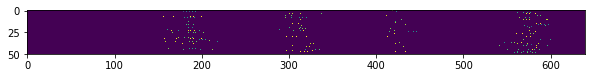

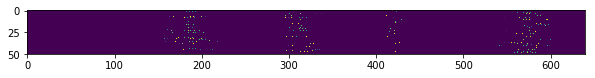

[[epoch 1]]:  training   batch 595/595
  average training   loss/batch = 0.0003844185602193808
          validation batch 58/58
                average validation nonzero mae/batch = 17.09994750187315

                average validation zero mae/batch = 0.024593470393326777


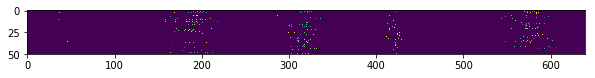

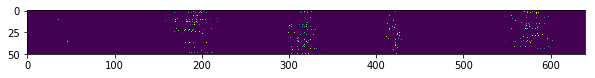

[[epoch 2]]:  training   batch 602/602
  average training   loss/batch = 0.0003707388060981952
          validation batch 58/58
                average validation nonzero mae/batch = 17.103816262606916

                average validation zero mae/batch = 0.02454496104398678


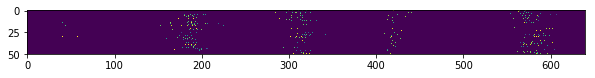

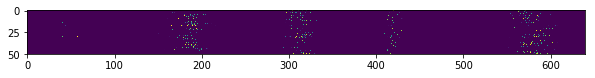

[[epoch 3]]:  training   batch 611/611
  average training   loss/batch = 0.00038205044920047146
          validation batch 58/58
                average validation nonzero mae/batch = 17.024418238935798

                average validation zero mae/batch = 0.025016704060394187


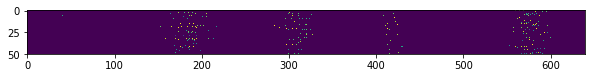

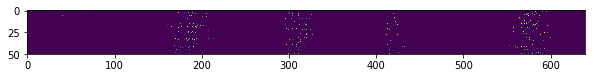

[[epoch 4]]:  training   batch 599/599
  average training   loss/batch = 0.00037378285920561504
          validation batch 58/58
                average validation nonzero mae/batch = 17.10172025088606

                average validation zero mae/batch = 0.024315961989863164


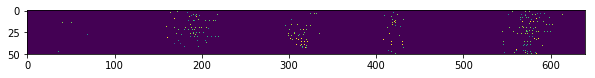

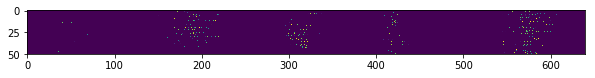

[[epoch 5]]:  training   batch 608/608
  average training   loss/batch = 0.00037108112174839906
          validation batch 58/58
                average validation nonzero mae/batch = 16.98520433491674

                average validation zero mae/batch = 0.024799719549201685


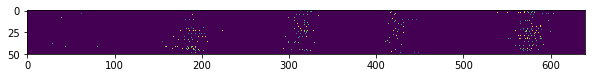

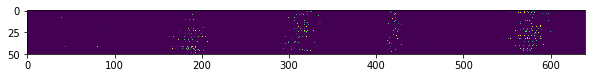

[[epoch 6]]:  training   batch 610/610
  average training   loss/batch = 0.0003684478510384921
          validation batch 58/58
                average validation nonzero mae/batch = 17.00414387933139

                average validation zero mae/batch = 0.02460380958328987


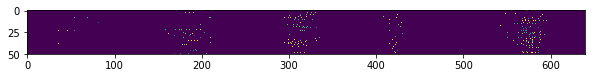

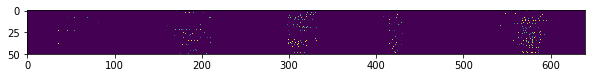

[[epoch 7]]:  training   batch 591/591
  average training   loss/batch = 0.0003816445094439502
          validation batch 58/58
                average validation nonzero mae/batch = 17.071236117132777

                average validation zero mae/batch = 0.024437350092519974


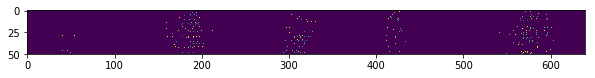

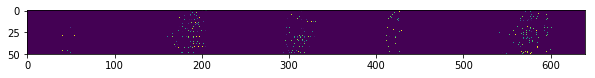

[[epoch 8]]:  training   batch 599/599
  average training   loss/batch = 0.00036878095591286875
          validation batch 58/58
                average validation nonzero mae/batch = 17.063337885100267

                average validation zero mae/batch = 0.02452056276901015


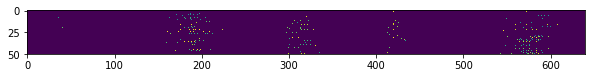

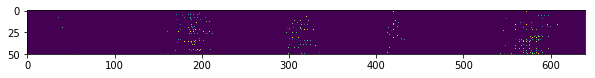

[[epoch 9]]:  training   batch 583/583
  average training   loss/batch = 0.0003866068804680528
          validation batch 58/58
                average validation nonzero mae/batch = 17.029224428637274

                average validation zero mae/batch = 0.024688133809330135


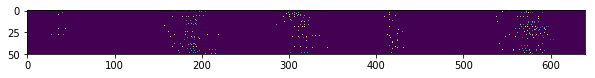

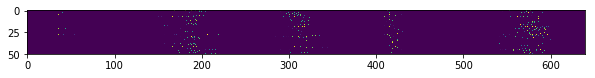

[[epoch 10]]:  training   batch 602/602
  average training   loss/batch = 0.00035544199336465585
          validation batch 58/58
                average validation nonzero mae/batch = 16.977337672792633

                average validation zero mae/batch = 0.024746184911707353


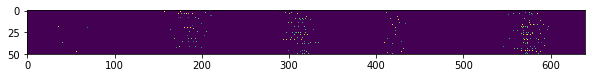

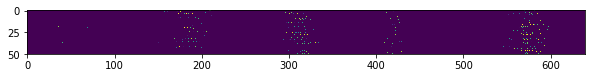

[[epoch 11]]:  training   batch 587/587
  average training   loss/batch = 0.00035797665837685713
          validation batch 58/58
                average validation nonzero mae/batch = 17.005325712006666

                average validation zero mae/batch = 0.024853874832905572


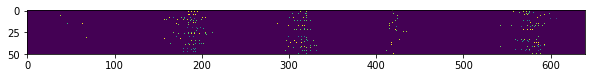

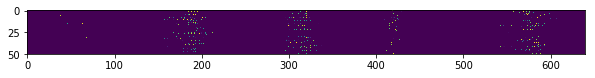

[[epoch 12]]:  training   batch 614/614
  average training   loss/batch = 0.00036723304971072714
          validation batch 58/58
                average validation nonzero mae/batch = 16.997902146701154

                average validation zero mae/batch = 0.024674794925697918


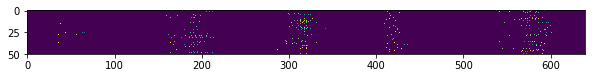

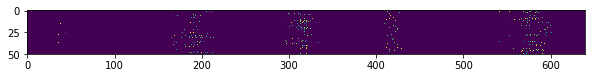

[[epoch 13]]:  training   batch 597/597
  average training   loss/batch = 0.0003504764265848801
          validation batch 58/58
                average validation nonzero mae/batch = 16.98780664904364

                average validation zero mae/batch = 0.024566610632785434


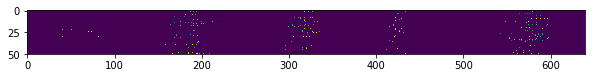

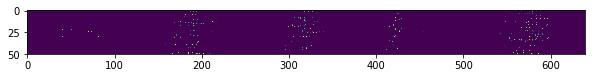

[[epoch 14]]:  training   batch 595/595
  average training   loss/batch = 0.00036872368092656513
          validation batch 58/58
                average validation nonzero mae/batch = 16.908251170454353

                average validation zero mae/batch = 0.024574494310494126


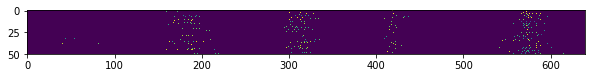

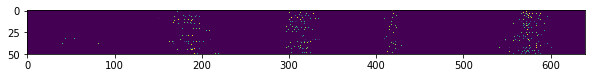

[[epoch 15]]:  training   batch 593/593
  average training   loss/batch = 0.0003393657124561256
          validation batch 58/58
                average validation nonzero mae/batch = 16.890055393350536

                average validation zero mae/batch = 0.024896345839932048


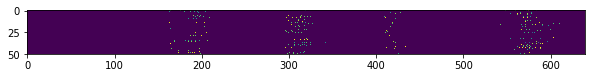

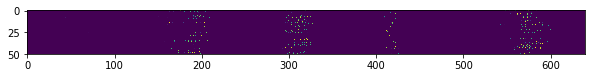

[[epoch 16]]:  training   batch 593/593
  average training   loss/batch = 0.00037989563259184614
          validation batch 58/58
                average validation nonzero mae/batch = 16.875561253777867

                average validation zero mae/batch = 0.025101380647513372


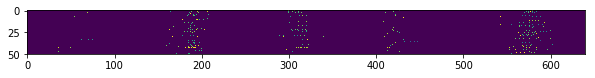

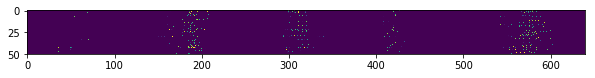

[[epoch 17]]:  training   batch 600/600
  average training   loss/batch = 0.00036761599748084945
          validation batch 58/58
                average validation nonzero mae/batch = 16.911447064629918

                average validation zero mae/batch = 0.024635768142239802


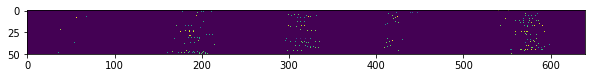

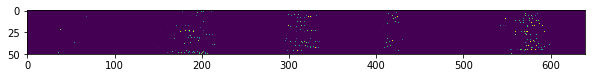

[[epoch 18]]:  training   batch 666/666
  average training   loss/batch = 0.00033929109955821803
          validation batch 58/58
                average validation nonzero mae/batch = 16.96587082435345

                average validation zero mae/batch = 0.023999789344339537


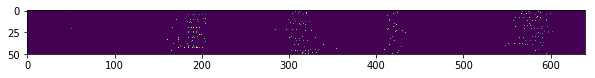

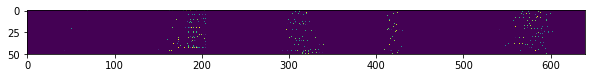

[[epoch 19]]:  training   batch 591/591
  average training   loss/batch = 0.00036691997831375314
          validation batch 58/58
                average validation nonzero mae/batch = 16.94105967159929

                average validation zero mae/batch = 0.024584390190911704


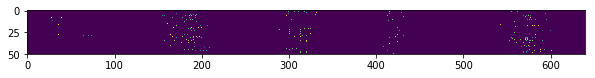

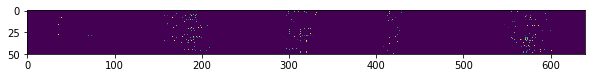

[[epoch 20]]:  training   batch 605/605
  average training   loss/batch = 0.0003552091453697779
          validation batch 58/58
                average validation nonzero mae/batch = 16.91114461833033

                average validation zero mae/batch = 0.024533556549456614


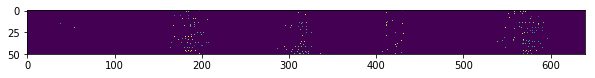

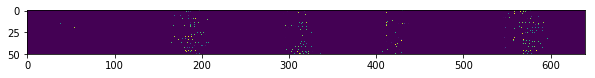

In [55]:
num_epochs = 21
epoch_size = 1000 # number of songs to load each epoch
batch_size = 1028*16 #after vstack, number of timestep
dl_num_worker = 48

# loading last 1400 songs in the validation data loader using the same batch size.
# want to use the same set of 1400 songs because we want to measure performance consistently.
# validation_data=data[-1400:-1350]
ds_val=PianorollDS(data_val[:100])
dl_val = DataLoader(ds_val, batch_size=batch_size, collate_fn=sparse2dense_collate,
                        shuffle=True, num_workers=dl_num_worker)

# normally, one epoch is going through the entire training dataset once.
# however, our entire dataset is too huge to load batches efficiently.
# so, one epoch here means to go through a `epoch_size` number of songs, and
# for the next epoch, we load another `epoch_size` number of songs.
# And for each epoch, we load batches as usual.
for j in range(1):
    print(f'=============== Cycle {j} ==============')
    for i_epoch in range(num_epochs):
        loss_cum=0; mae_cum0=0; mae_cum1=0; 
        ds = PianorollDS(data[i_epoch*epoch_size : (1+i_epoch)*epoch_size])
        dl = DataLoader(ds, batch_size=batch_size, collate_fn=sparse2dense_collate,
                        shuffle=True, num_workers=dl_num_worker)
        num_batches = len(ds)//batch_size

        for i_batch, di in enumerate(iter(dl)): # enumerate(iterator) returns a tuple: (ith loop, actual next(iterator))
#             autoencoder.train()
            di=velocityTransform(di.cuda())
            optimizer.zero_grad()
            encoding,preds=autoencoder(di)
            loss=0.5*loss_fn(preds[:,1:,:], di[:,1:,:]) + 0.5*loss_fn(preds[:,0,:], di[:,0,:])
#             loss=loss_fn(preds, di)
            loss.backward()
            loss_cum+=loss.item()
            optimizer.step()
            print('[[epoch '+str(i_epoch)+']]:  training   batch '+ str(i_batch) + '/' + str(num_batches), end='\r') # end='\r' means continuesly refreshing same line of output
        print('\n  average training   loss/batch =', loss_cum/num_batches)

        # starting validation: load one batch each loop after one epoch of traing loop
        for i_batch_val,di_val in enumerate(iter(dl_val)):
#             autoencoder.eval()
            di_val=velocityTransform(di_val.cuda())
            encoding,preds=autoencoder(di_val)
            mask1 = di_val.gt(0)
            valMAE0=mean_absolute_error(velocityDetransform(preds[~mask1]).type(torch.float),velocityDetransform(di_val[~mask1]).type(torch.float))
            valMAE1=mean_absolute_error(velocityDetransform(preds[mask1]).type(torch.float),velocityDetransform(di_val[mask1]).type(torch.float))
            mae_cum0+=valMAE0.item()
            mae_cum1+=valMAE1.item()
            print('          validation batch '+ str(i_batch_val) + '/' + str(len(ds_val)//batch_size), end='\r')
        print('\n                average validation nonzero mae/batch =', mae_cum1/(len(ds_val)//batch_size))
        print('\n                average validation zero mae/batch =', mae_cum0/(len(ds_val)//batch_size))
        plt.imshow(velocityDetransform(di_val.cpu()).numpy()[:50].reshape(-1,640))
        plt.show()
        plt.imshow(velocityDetransform(preds.detach().cpu()).numpy()[:50].reshape(-1,640))
        plt.show()
#         loss_cum=0; mae_cum=0

In [56]:
torch.save(autoencoder.state_dict(), './conv_AE_drumFirst_allData-04.pth')

# Encoding function with the trained model:
### Takes a song (sparse matrix) and feed to model, extract the middle encoding (3 chanel, 32 pixel tall, [timesteps] long), fold the time dimension to make things square-ish, then visualize by plotting as RGB image

In [57]:
def encode_song(sparse_song, staff_width = 512, staff_height=29, fname=None):
    autoencoder.eval()

    enc,_ = autoencoder(velocityTransform(torch.from_numpy(
        sparse_song.toarray().reshape(-1,128,5).transpose(0,2,1)
        )).cuda())

    song = enc.detach().cpu().numpy().transpose((2,0,1))

    song_folded = np.vstack(np.hsplit(np.pad(song, ((0,3),(0,staff_width-song.shape[1]%staff_width),(0,0)),'constant'),1+song.shape[1]//staff_width))

    if fname is not None:
        plt.imsave('imgs/'+fname, song_folded)
        print(fname+' saved', end='\r')
    else:
        plt.imshow(song_folded)
        plt.show()

# Pick 30 songs to visualize their encoding

==== song 2500 ====


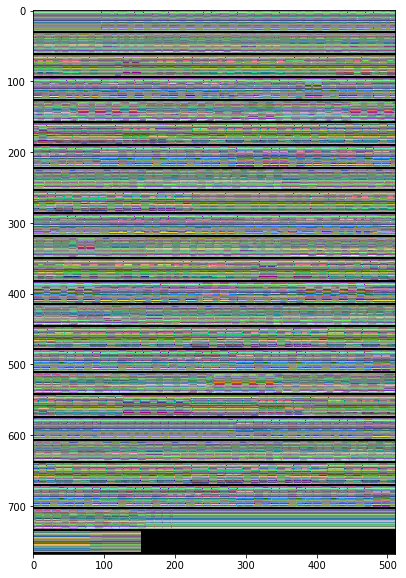

==== song 2501 ====


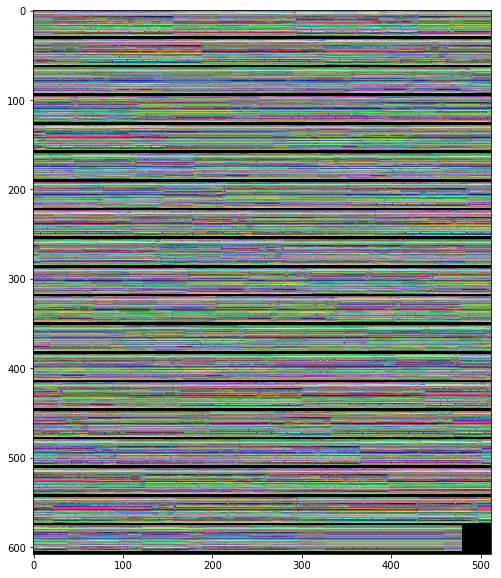

==== song 2502 ====


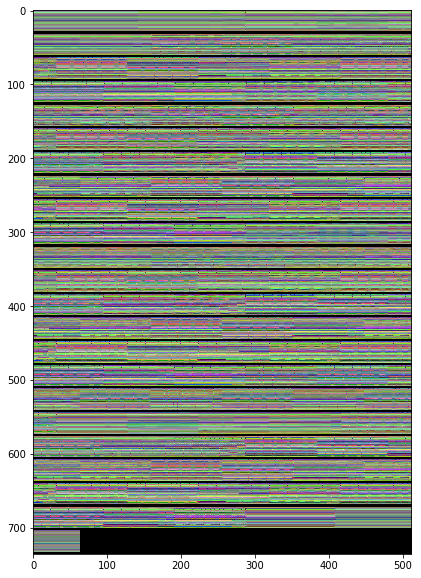

==== song 2503 ====


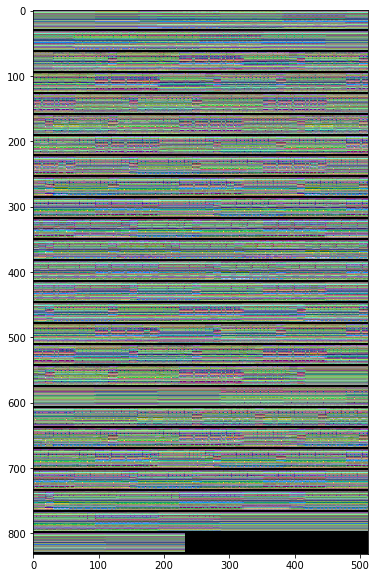

==== song 2504 ====


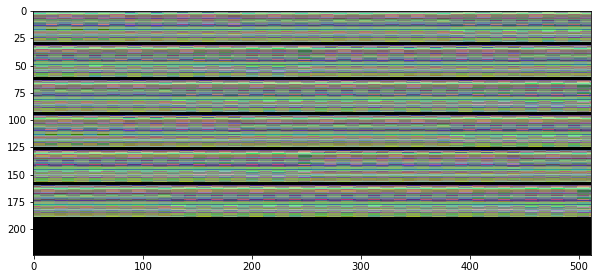

==== song 2505 ====


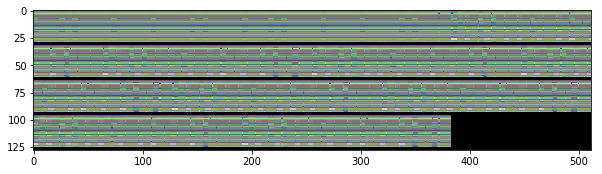

==== song 2506 ====


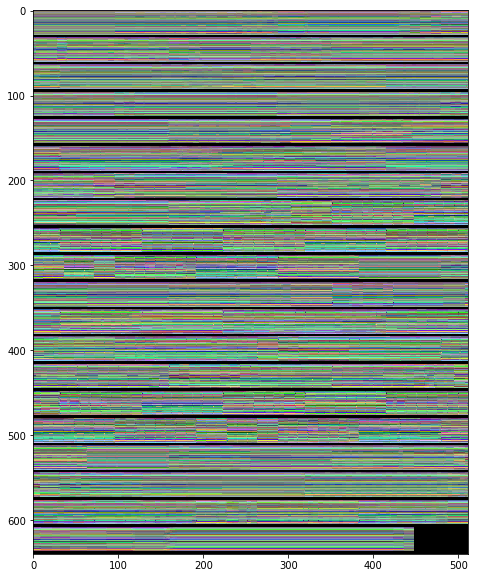

==== song 2507 ====


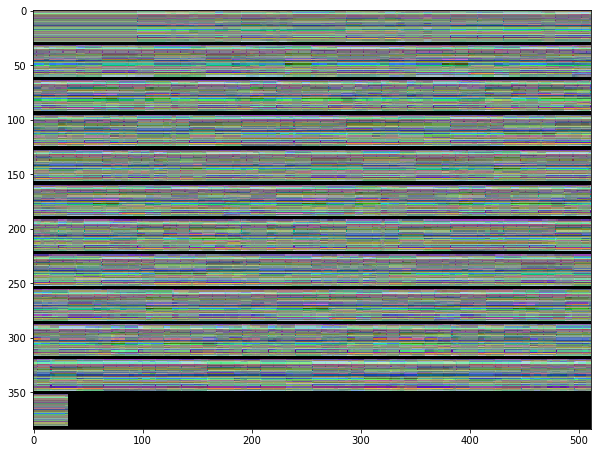

==== song 2508 ====


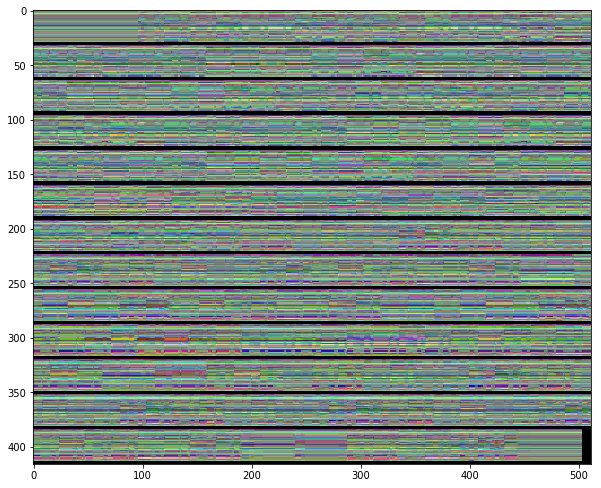

==== song 2509 ====


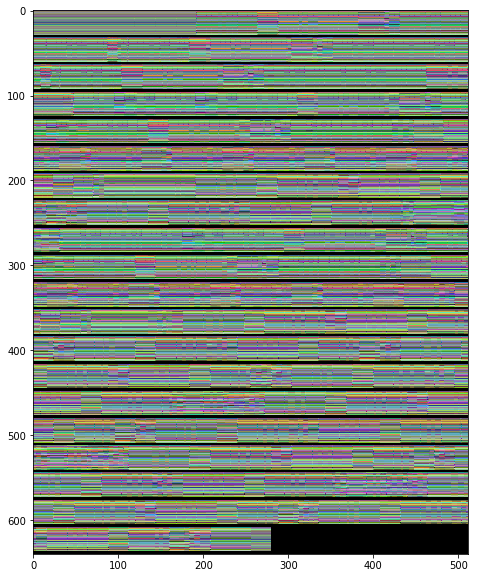

==== song 2510 ====


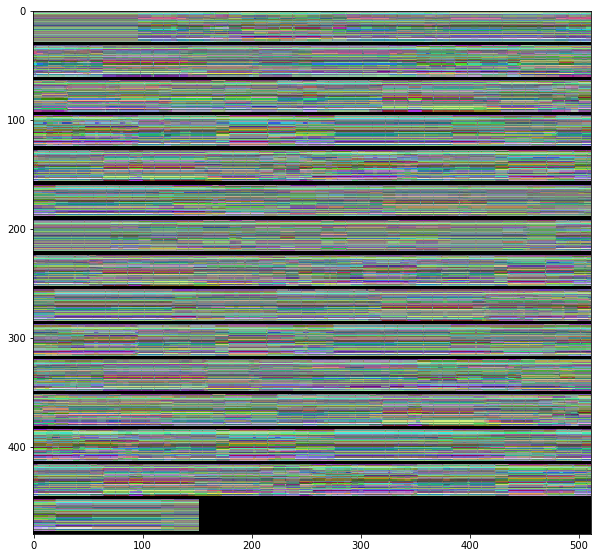

==== song 2511 ====


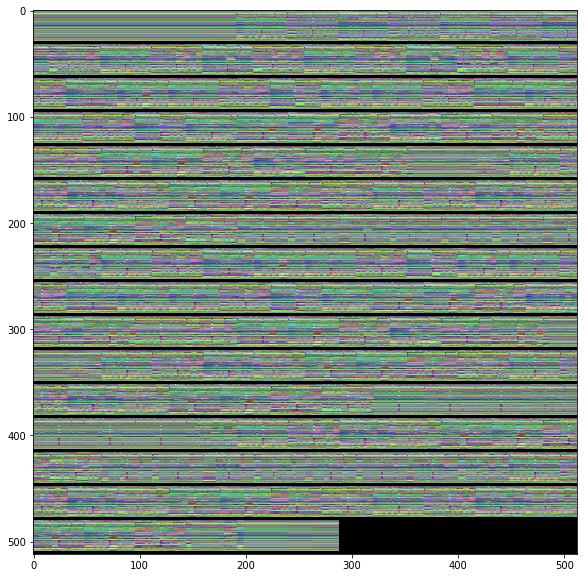

==== song 2512 ====


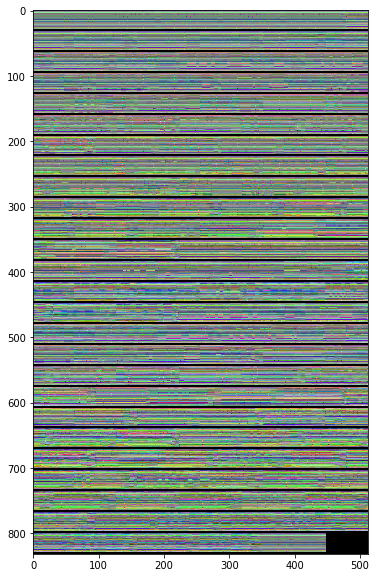

==== song 2513 ====


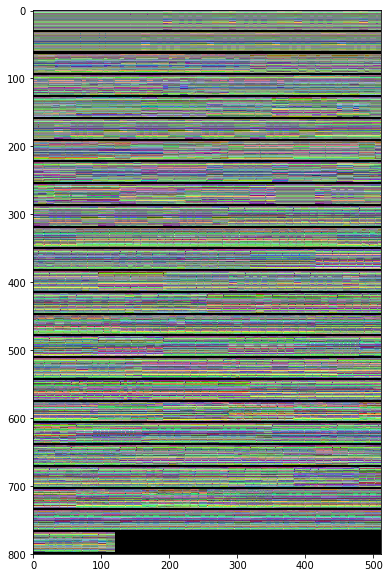

==== song 2514 ====


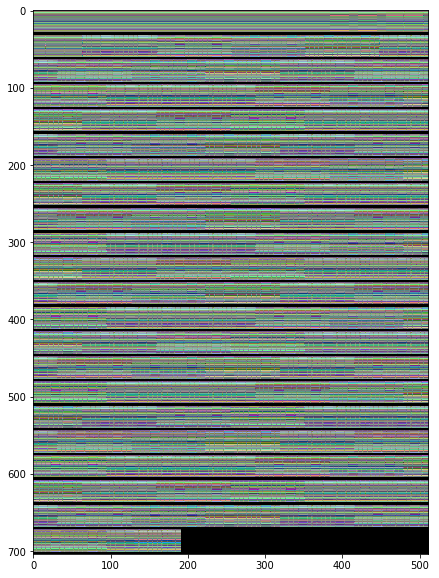

==== song 2515 ====


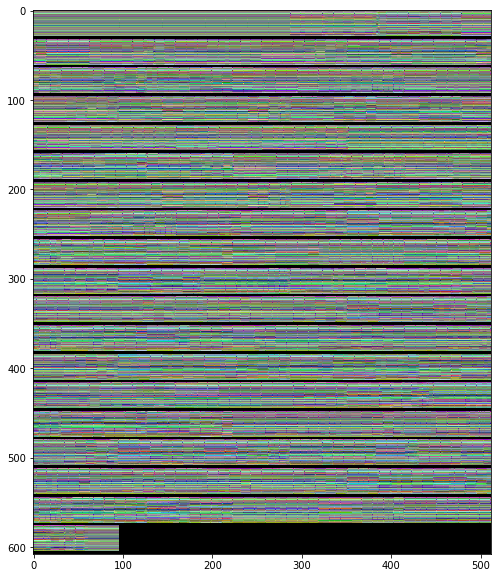

==== song 2516 ====


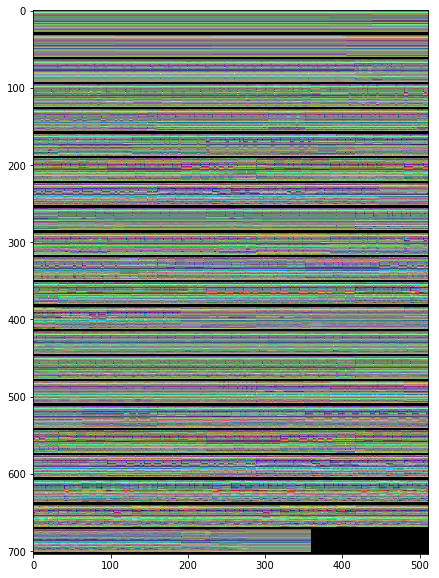

==== song 2517 ====


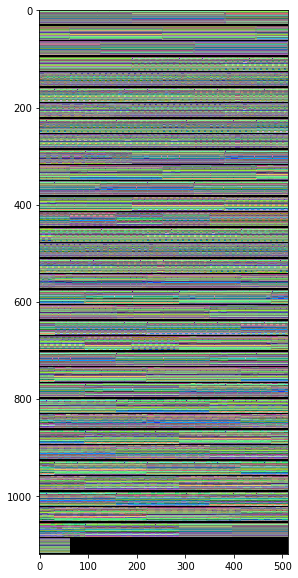

==== song 2518 ====


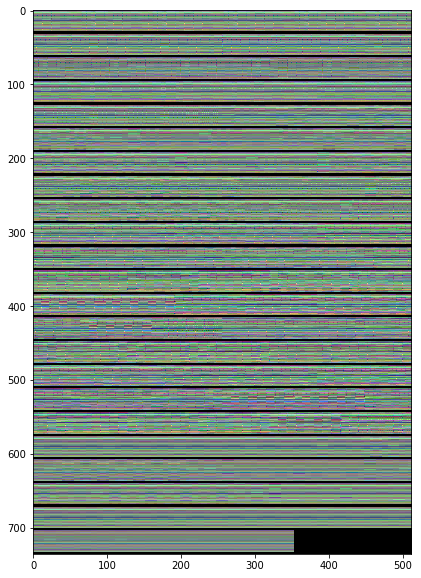

==== song 2519 ====


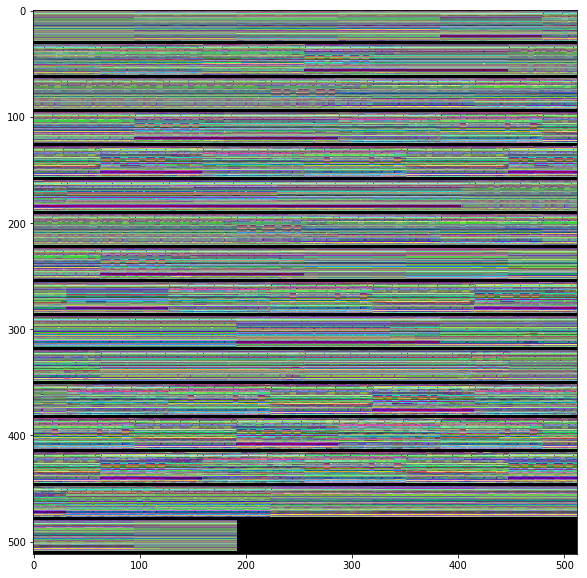

==== song 2520 ====


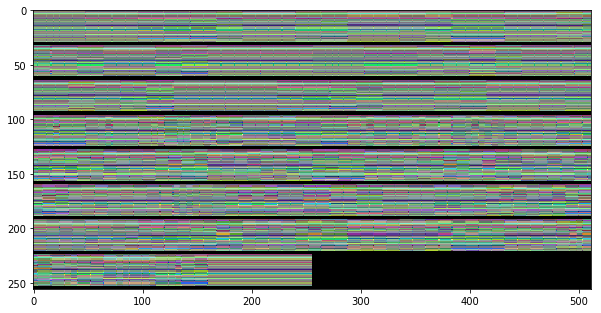

==== song 2521 ====


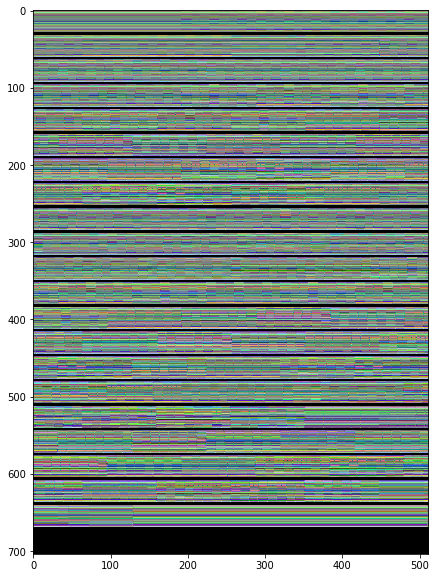

==== song 2522 ====


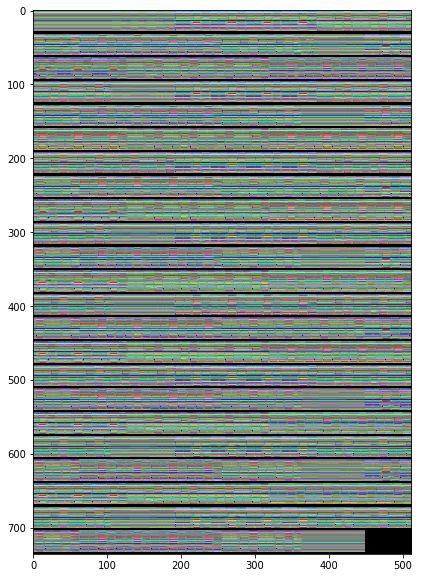

==== song 2523 ====


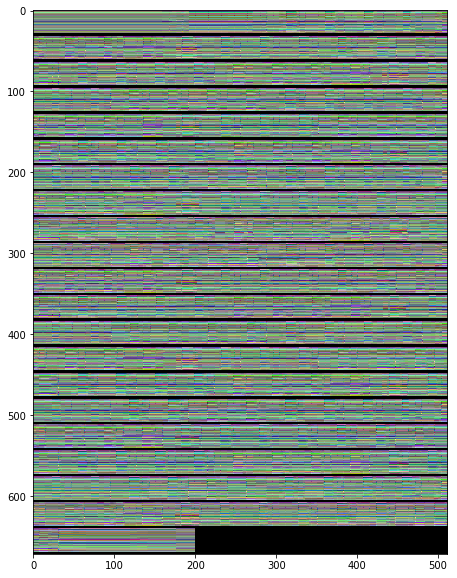

==== song 2524 ====


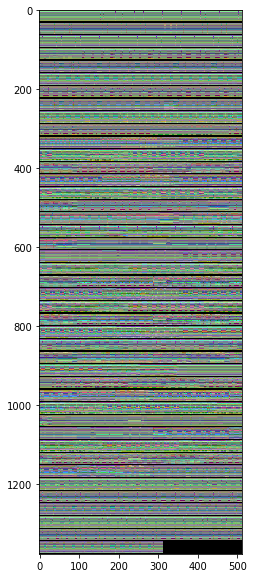

==== song 2525 ====


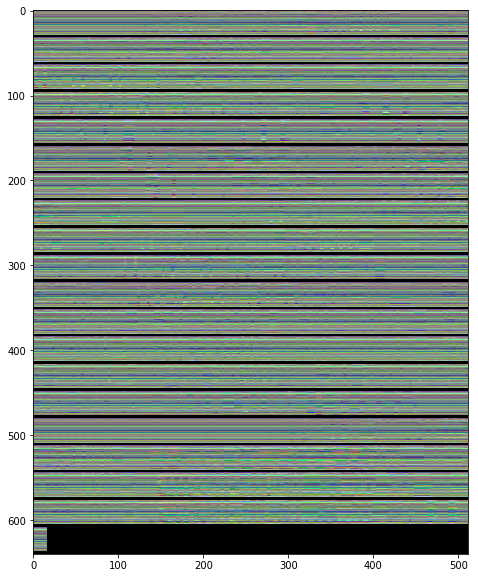

==== song 2526 ====


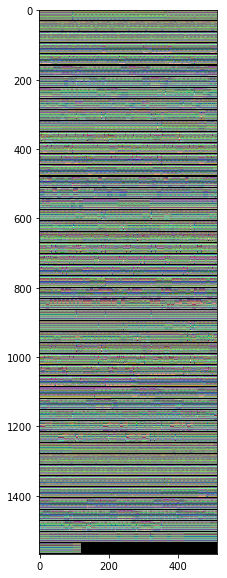

==== song 2527 ====


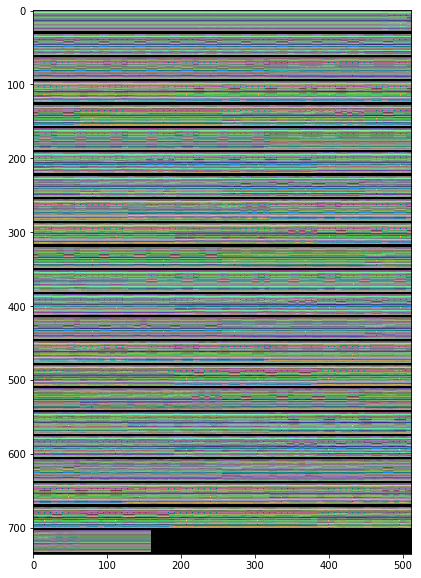

==== song 2528 ====


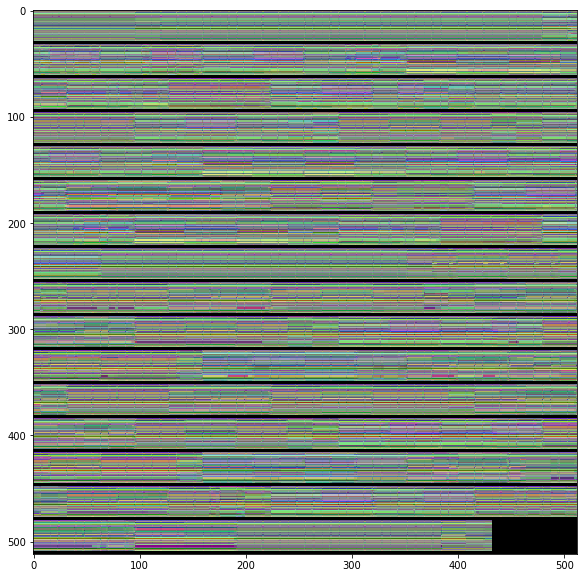

==== song 2529 ====


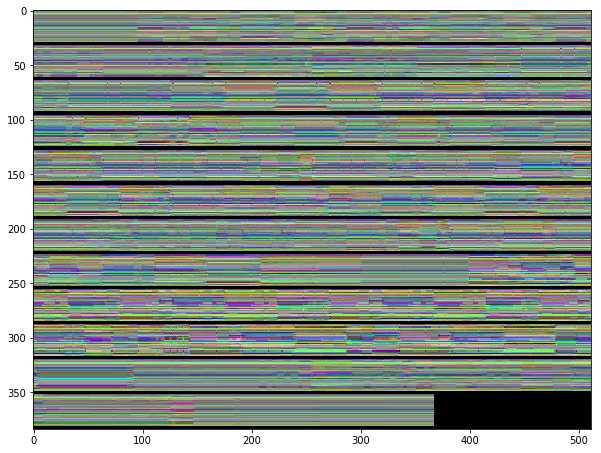

In [58]:
for i in range(2500,2530):
    print(f'==== song {i} ====')
    encode_song(data[i])
    

In [102]:
for i in range(len(data)):
    encode_song(data[i], fname=f'midi_{i:05d}.png')
    

In [91]:
encIm = plt.imread('imgs_2/midi_002501.png')

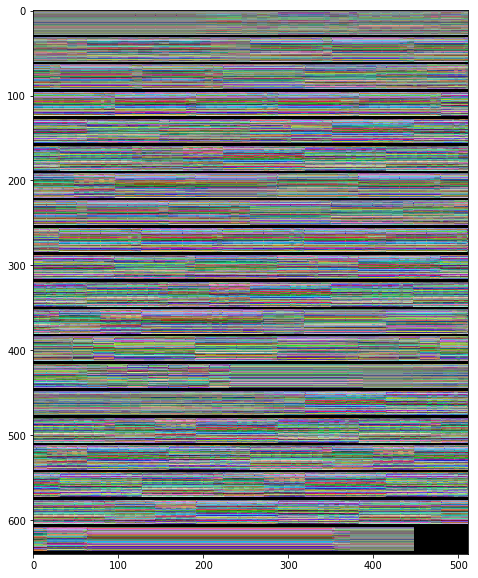

In [92]:
plt.imshow(encIm)